# PUSTU CHATBOT - TRAINING NOTEBOOK

## Chatbot Anamnesis PUSTU Berbasis NLP + Naive Bayes

In [105]:
!pip install pandas numpy scikit-learn matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Import Libraries

In [106]:
import re
import json
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully")

Libraries imported successfully


## 2. Load Dataset

In [107]:
# Load dataset and remove jawab_gejala intent
df = pd.read_csv('data/raw/dataset_anamnesis_20251202_162631.csv')

print(f'Original dataset:')
print(f'Total: {len(df)} samples')
print(f'Intents: {df["Intent"].nunique()}')
print(f'\nIntent distribution BEFORE filtering:')
print(df['Intent'].value_counts().sort_index())

# REMOVE jawab_gejala intent (overlaps with keluhan_utama and jawab_gejala_penyerta)
df_filtered = df[df['Intent'] != 'jawab_gejala'].copy()

print(f'\n{"="*80}')
print(f'FILTERED dataset (jawab_gejala REMOVED):')
print(f'Total: {len(df_filtered)} samples')
print(f'Intents: {df_filtered["Intent"].nunique()}')
print(f'\nIntent distribution AFTER filtering:')
print(df_filtered['Intent'].value_counts().sort_index())

# Use filtered dataset for training
df = df_filtered

print(f'\n{"="*80}')
print('✓ Dataset ready for training with 14 intents (jawab_gejala removed)')
df.head()

Original dataset:
Total: 15000 samples
Intents: 15

Intent distribution BEFORE filtering:
Intent
jawab_alergi              1000
jawab_durasi              1000
jawab_faktor_risiko       1000
jawab_gejala              1000
jawab_gejala_penyerta     1000
jawab_lokasi              1000
jawab_riwayat_obat        1000
jawab_riwayat_penyakit    1000
jawab_severity            1000
keluhan_utama             1000
konfirmasi                1000
penyangkalan              1000
sapaan                    1000
tidak_jelas               1000
ucapan_terima_kasih       1000
Name: count, dtype: int64

FILTERED dataset (jawab_gejala REMOVED):
Total: 14000 samples
Intents: 14

Intent distribution AFTER filtering:
Intent
jawab_alergi              1000
jawab_durasi              1000
jawab_faktor_risiko       1000
jawab_gejala_penyerta     1000
jawab_lokasi              1000
jawab_riwayat_obat        1000
jawab_riwayat_penyakit    1000
jawab_severity            1000
keluhan_utama             1000
konfirmasi   

,ID,Raw_Text,Intent,Symptoms,Duration,Location,Severity,Case_Category
0,1,Badan saya terasa lemas dan demam sejak dua ha...,keluhan_utama,"demam,lemas",2 hari,,sedang,Diabetes
1,2,Saya mengalami sesak napas disertai batuk berd...,keluhan_utama,"batuk,sesak",7 hari,,sedang,ISPA
2,3,Perut saya terasa nyeri di bagian ulu hati set...,keluhan_utama,nyeri,,ulu hati,sedang,Gastritis
3,4,Kulit saya gatal-gatal dan muncul ruam merah d...,keluhan_utama,"gatal,ruam",5 hari,lengan,sedang,Dermatitis
4,5,"Tekanan darah saya sering naik, terutama saat ...",keluhan_utama,,,,sedang,


In [108]:
df['Intent'].value_counts().sort_index()

Intent
jawab_alergi              1000
jawab_durasi              1000
jawab_faktor_risiko       1000
jawab_gejala_penyerta     1000
jawab_lokasi              1000
jawab_riwayat_obat        1000
jawab_riwayat_penyakit    1000
jawab_severity            1000
keluhan_utama             1000
konfirmasi                1000
penyangkalan              1000
sapaan                    1000
tidak_jelas               1000
ucapan_terima_kasih       1000
Name: count, dtype: int64

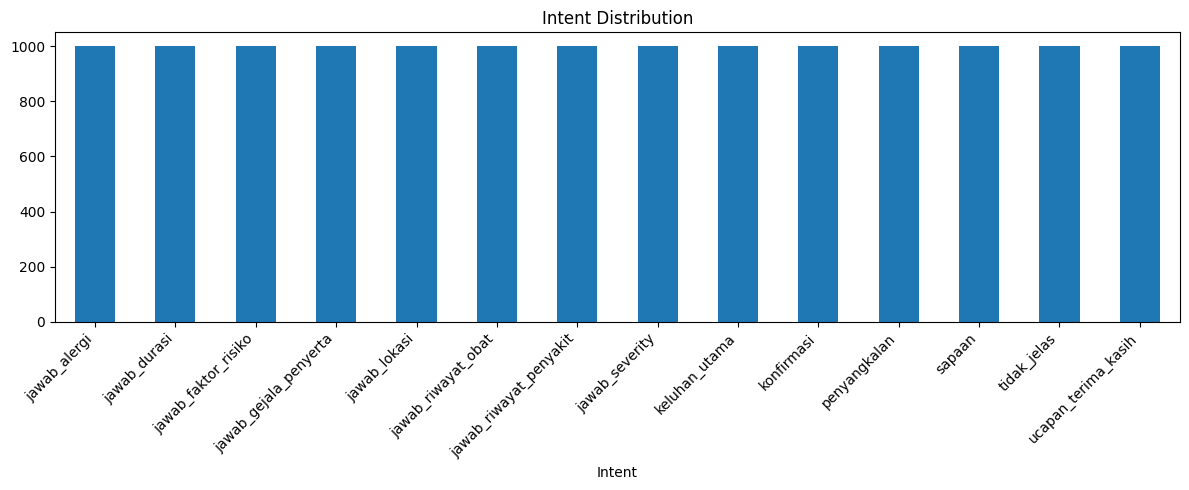

In [109]:
plt.figure(figsize=(12,5))
df['Intent'].value_counts().sort_index().plot(kind='bar')
plt.title('Intent Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('outputs/figures/intent_distribution.png', dpi=300)
plt.show()

## 3. Load Dictionaries

In [110]:
with open('data/dictionaries/stopwords_id.txt', 'r') as f:
    stopwords = set(line.strip() for line in f)

with open('data/dictionaries/slang_normalization.json', 'r') as f:
    slang_dict = json.load(f)

print(f'Stopwords: {len(stopwords)}')
print(f'Slang: {len(slang_dict)}')

Stopwords: 93
Slang: 94


## 4. Preprocessing

In [111]:
def preprocess(text, slang_dict, stopwords):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    words = text.split()
    words = [slang_dict.get(w, w) for w in words]
    words = [w for w in words if w not in stopwords]
    return ' '.join(words)

test = 'Saya demam udah 3 hari gak sembuh'
print(f'Original: {test}')
print(f'Processed: {preprocess(test, slang_dict, stopwords)}')

Original: Saya demam udah 3 hari gak sembuh
Processed: demam sudah 3 hari tidak sembuh


## 4.5. Dataset Processing & Saving

In [112]:
import os
from datetime import datetime

# Create processed directory
os.makedirs('data/processed', exist_ok=True)

# Apply preprocessing to all data
df['Processed_Text'] = df['Raw_Text'].apply(lambda x: preprocess(x, slang_dict, stopwords))

# Add statistics columns
df['Text_Length'] = df['Raw_Text'].str.len()
df['Processed_Length'] = df['Processed_Text'].str.len()
df['Word_Count'] = df['Processed_Text'].str.split().str.len()

# Save processed dataset
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
processed_path = f'data/processed/dataset_processed_{timestamp}.csv'
df.to_csv(processed_path, index=False, encoding='utf-8')

print(f'Processed dataset saved: {processed_path}')
print(f'Statistics:')
print(f'- Original avg length: {df["Text_Length"].mean():.1f} chars')
print(f'- Processed avg length: {df["Processed_Length"].mean():.1f} chars')
print(f'- Avg word count: {df["Word_Count"].mean():.1f} words')
print(f'- Text reduction: {((df["Text_Length"].mean() - df["Processed_Length"].mean()) / df["Text_Length"].mean() * 100):.1f}%')

Processed dataset saved: data/processed/dataset_processed_20251202_195300.csv
Statistics:
- Original avg length: 51.3 chars
- Processed avg length: 38.7 chars
- Avg word count: 5.8 words
- Text reduction: 24.6%


In [113]:
# Compare original vs processed
comparison_df = df[['Intent', 'Raw_Text', 'Processed_Text']].head(5)
print('Sample Comparison (Original vs Processed):')
print('='*80)
for idx, row in comparison_df.iterrows():
    print(f"Intent: {row['Intent']}")
    print(f"Original:  {row['Raw_Text']}")
    print(f"Processed: {row['Processed_Text']}")
    print('-'*80)

Sample Comparison (Original vs Processed):
Intent: keluhan_utama
Original:  Badan saya terasa lemas dan demam sejak dua hari lalu.
Processed: badan terasa lemas demam sejak dua hari lalu
--------------------------------------------------------------------------------
Intent: keluhan_utama
Original:  Saya mengalami sesak napas disertai batuk berdahak selama seminggu ini.
Processed: mengalami sesak napas disertai batuk berdahak selama seminggu
--------------------------------------------------------------------------------
Intent: keluhan_utama
Original:  Perut saya terasa nyeri di bagian ulu hati setelah makan, sudah sekitar 3 hari.
Processed: perut terasa nyeri bagian ulu hati setelah makan sudah sekitar 3 hari
--------------------------------------------------------------------------------
Intent: keluhan_utama
Original:  Kulit saya gatal-gatal dan muncul ruam merah di lengan, kira-kira 5 hari yang lalu.
Processed: kulit gatal gatal muncul ruam merah lengan kira kira 5 hari lalu
-----

## 5. Verify Processed Data

In [114]:
# Verify the processed text column (already created in section 2.5)
print('Sample of processed data:')
print(df[['Raw_Text', 'Processed_Text']].head(3))

Sample of processed data:
                                            Raw_Text  \
0  Badan saya terasa lemas dan demam sejak dua ha...   
1  Saya mengalami sesak napas disertai batuk berd...   
2  Perut saya terasa nyeri di bagian ulu hati set...   

                                      Processed_Text  
0       badan terasa lemas demam sejak dua hari lalu  
1  mengalami sesak napas disertai batuk berdahak ...  
2  perut terasa nyeri bagian ulu hati setelah mak...  


## 6. Train-Test Split

In [115]:
X = df['Processed_Text']
y = df['Intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'Train: {len(X_train)}, Test: {len(X_test)}')

Train: 11200, Test: 2800


## 7. TF-IDF

In [116]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print(f'Vocab: {len(vectorizer.vocabulary_)}')
print(f'Shape: {X_train_tfidf.shape}')

Vocab: 5000
Shape: (11200, 5000)


## 8. Train Model

In [117]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_tfidf, y_train)
print('Model trained')

Model trained


## 9. Evaluation

In [118]:
y_pred = model.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.2%}')

Accuracy: 92.61%


In [119]:
print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

          jawab_alergi       0.87      0.97      0.92       200
          jawab_durasi       0.92      0.94      0.93       200
   jawab_faktor_risiko       0.98      0.84      0.91       200
 jawab_gejala_penyerta       0.90      0.90      0.90       200
          jawab_lokasi       0.93      0.96      0.95       200
    jawab_riwayat_obat       0.97      0.99      0.98       200
jawab_riwayat_penyakit       0.87      0.90      0.88       200
        jawab_severity       0.91      0.88      0.89       200
         keluhan_utama       0.82      0.87      0.84       200
            konfirmasi       0.97      0.84      0.90       200
          penyangkalan       0.98      0.95      0.96       200
                sapaan       0.98      0.98      0.98       200
           tidak_jelas       0.97      0.96      0.97       200
   ucapan_terima_kasih       0.94      0.97      0.96       200

              accuracy                

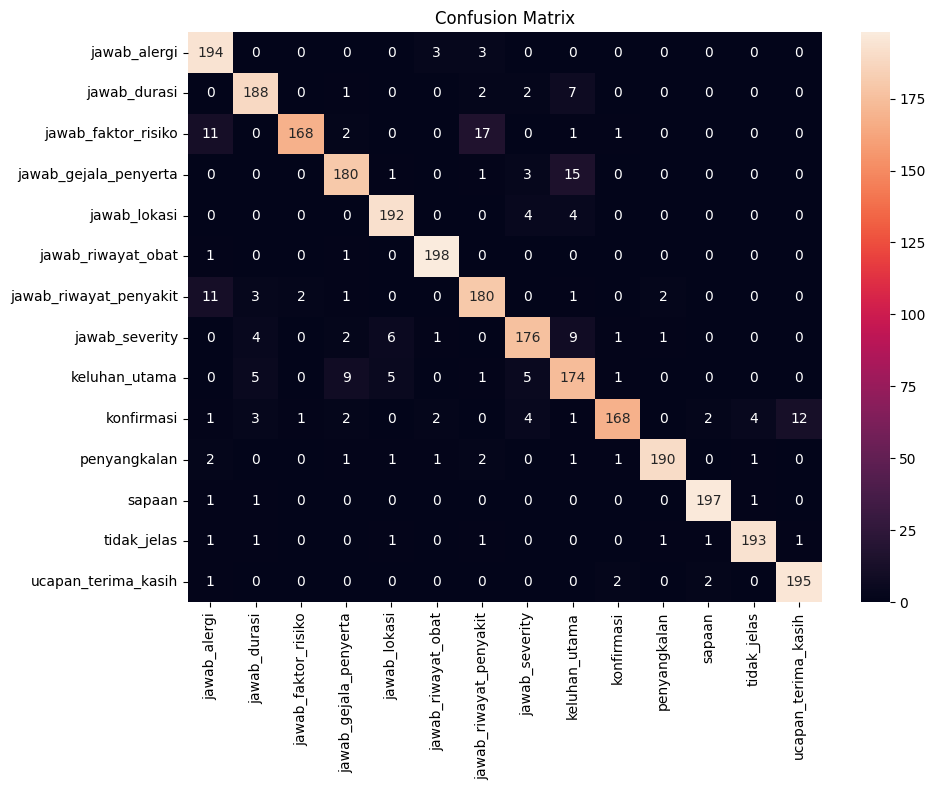

In [120]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('outputs/figures/confusion_matrix.png', dpi=300)
plt.show()

## 10. Entity Extraction (NER)

In [121]:
# Load dictionaries for entity extraction
with open('data/dictionaries/symptoms_dict.json', 'r', encoding='utf-8') as f:
    symptoms_dict = json.load(f)

with open('data/dictionaries/severity_keywords.json', 'r', encoding='utf-8') as f:
    severity_dict = json.load(f)

# location_dict already loaded in cell 30, but we'll reload here for completeness
with open('data/dictionaries/location_keywords.json', 'r', encoding='utf-8') as f:
    location_dict = json.load(f)

print(f'Loaded dictionaries:')
print(f'- Symptoms: {len(symptoms_dict)} entries')
print(f'- Severity: {len(severity_dict)} levels')
print(f'- Locations: {len(location_dict)} body parts')


class EntityExtractor:
    """Comprehensive entity extraction for medical anamnesis"""
    
    def __init__(self, symptoms_dict, severity_dict, location_dict):
        self.symptoms_dict = symptoms_dict
        self.severity_dict = severity_dict
        self.location_dict = location_dict
    
    def extract_nama(self, text):
        """Extract patient name from text"""
        pattern = r'nama\s+(?:saya\s+)?(\w+(?:\s+\w+)?)'
        match = re.search(pattern, text.lower())
        if match:
            return match.group(1).title()
        return None
    
    def extract_umur(self, text):
        """Extract age from text"""
        pattern = r'(\d+)\s*(?:tahun|th|thn)'
        match = re.search(pattern, text.lower())
        if match:
            return int(match.group(1))
        return None
    
    def extract_jenis_kelamin(self, text):
        """Extract gender from text"""
        text_lower = text.lower()
        if any(word in text_lower for word in ['laki-laki', 'laki', 'pria', 'cowok', 'cowo']):
            return 'Laki-laki'
        elif any(word in text_lower for word in ['perempuan', 'wanita', 'cewek', 'cewe']):
            return 'Perempuan'
        return None
    
    def extract_durasi(self, text):
        """Extract duration from text (excluding age mentions)"""
        text_lower = text.lower()
        
        # Pattern 1: Duration with context keywords (for all time units including tahun)
        # This prevents "28 tahun" (age) from being matched, requires duration context
        duration_contexts = ['sudah', 'sejak', 'selama', 'sekitar', 'kurang lebih', 'kira-kira', 
                           'hampir', 'lebih dari', 'sekitar']
        for context in duration_contexts:
            pattern = rf'{context}\s+(\d+)\s*(?:hari|minggu|bulan|tahun|jam|menit)'
            match = re.search(pattern, text_lower)
            if match:
                return match.group(0)
        
        # Pattern 2: Simple patterns for hari/minggu/bulan (safe without context)
        # Don't include 'tahun' here to avoid confusion with age
        simple_pattern = r'(\d+)\s*(?:hari|minggu|bulan)'
        match = re.search(simple_pattern, text_lower)
        if match:
            return match.group(0)
        
        # Pattern 3: Relative time expressions
        relative_pattern = r'sejak\s+(?:kemarin|lusa|seminggu|sebulan|tadi|pagi|siang|sore|malam)'
        match = re.search(relative_pattern, text_lower)
        if match:
            return match.group(0)
        
        return None
    
    def extract_lokasi(self, text):
        """Extract body location from text"""
        text_lower = text.lower()
        for location, keywords in self.location_dict.items():
            for keyword in keywords:
                if keyword in text_lower:
                    return location
        return None
    
    def extract_severity(self, text):
        """Extract severity level from text"""
        text_lower = text.lower()
        for severity, info in self.severity_dict.items():
            for keyword in info['keywords']:
                if keyword in text_lower:
                    return severity
        return 'sedang'  # default if not found
    
    def extract_symptoms(self, text):
        """Extract symptoms from text"""
        text_lower = text.lower()
        found_symptoms = []
        for symptom, info in self.symptoms_dict.items():
            # Check main symptom
            if symptom in text_lower:
                found_symptoms.append(symptom)
            # Check synonyms
            for synonym in info.get('synonyms', []):
                if synonym in text_lower and symptom not in found_symptoms:
                    found_symptoms.append(symptom)
        return found_symptoms
    
    def extract_all(self, text):
        """Extract all entities from text"""
        return {
            'nama': self.extract_nama(text),
            'umur': self.extract_umur(text),
            'jenis_kelamin': self.extract_jenis_kelamin(text),
            'durasi': self.extract_durasi(text),
            'lokasi': self.extract_lokasi(text),
            'severity': self.extract_severity(text),
            'symptoms': self.extract_symptoms(text)
        }


# Initialize entity extractor
extractor = EntityExtractor(symptoms_dict, severity_dict, location_dict)

# Test entity extraction with edge cases
test_cases = [
    'Nama saya Budi, umur 35 tahun, laki-laki',  # Should NOT extract durasi
    'Saya demam sudah 3 hari, sakitnya parah banget',  # Should extract "sudah 3 hari"
    'Kepala saya sakit ringan sejak kemarin',  # Should extract "sejak kemarin"
    'Batuk saya 2 minggu, semakin parah',  # Should extract "2 minggu"
    'Sudah 2 tahun saya menderita diabetes'  # Should extract "sudah 2 tahun"
]

print('\nEntity Extraction Test (Fixed Duration):')
print('=' * 80)
for test_text in test_cases:
    entities = extractor.extract_all(test_text)
    print(f'Text: {test_text}')
    print(f'Extracted:')
    print(f'  - nama: {entities["nama"]}')
    print(f'  - umur: {entities["umur"]}')
    print(f'  - jenis_kelamin: {entities["jenis_kelamin"]}')
    print(f'  - durasi: {entities["durasi"]}')
    print(f'  - lokasi: {entities["lokasi"]}')
    print('-' * 80)

Loaded dictionaries:
- Symptoms: 24 entries
- Severity: 3 levels
- Locations: 23 body parts

Entity Extraction Test (Fixed Duration):
Text: Nama saya Budi, umur 35 tahun, laki-laki
Extracted:
  - nama: Budi
  - umur: 35
  - jenis_kelamin: Laki-laki
  - durasi: None
  - lokasi: None
--------------------------------------------------------------------------------
Text: Saya demam sudah 3 hari, sakitnya parah banget
Extracted:
  - nama: None
  - umur: None
  - jenis_kelamin: None
  - durasi: sudah 3 hari
  - lokasi: None
--------------------------------------------------------------------------------
Text: Kepala saya sakit ringan sejak kemarin
Extracted:
  - nama: None
  - umur: None
  - jenis_kelamin: None
  - durasi: sejak kemarin
  - lokasi: kepala
--------------------------------------------------------------------------------
Text: Batuk saya 2 minggu, semakin parah
Extracted:
  - nama: None
  - umur: None
  - jenis_kelamin: None
  - durasi: 2 minggu
  - lokasi: None
---------------

## 11. Dialog State Manager

In [122]:
class DialogStateManager:
    def __init__(self):
        self.state = 'greeting'
        self.data = {}
        self.flow = [
            'greeting', 'keluhan_utama', 'gejala', 'durasi',
            'lokasi', 'severity', 'riwayat_penyakit',
            'riwayat_obat', 'alergi', 'faktor_risiko', 'summary'
        ]
        
    def get_next_state(self):
        current_idx = self.flow.index(self.state)
        if current_idx < len(self.flow) - 1:
            return self.flow[current_idx + 1]
        return 'summary'
    
    def update(self, intent, entities):
        self.data[intent] = entities
        self.state = self.get_next_state()
        
    def reset(self):
        self.state = 'greeting'
        self.data = {}

dsm = DialogStateManager()
print(f'Initial state: {dsm.state}')
print(f'Next state: {dsm.get_next_state()}')

Initial state: greeting
Next state: keluhan_utama


### Simulate Dialog Flow

In [123]:
dsm = DialogStateManager()
test_flow = [
    ('keluhan_utama', {'symptom': 'demam'}),
    ('jawab_durasi', {'durasi': '3 hari'}),
    ('jawab_severity', {'severity': 'parah'}),
]

for intent, entities in test_flow:
    dsm.update(intent, entities)
    print(f'Intent: {intent}, State: {dsm.state}')
    
print(f'Collected data: {dsm.data}')

Intent: keluhan_utama, State: keluhan_utama
Intent: jawab_durasi, State: gejala
Intent: jawab_severity, State: durasi
Collected data: {'keluhan_utama': {'symptom': 'demam'}, 'jawab_durasi': {'durasi': '3 hari'}, 'jawab_severity': {'severity': 'parah'}}


## 12. Test Predictions

In [124]:
def predict_with_details(text):
    """Predict intent with full entity extraction"""
    processed = preprocess(text, slang_dict, stopwords)
    tfidf = vectorizer.transform([processed])
    pred = model.predict(tfidf)[0]
    proba = model.predict_proba(tfidf)[0]
    confidence = max(proba)
    
    # Use comprehensive entity extractor
    entities = extractor.extract_all(text)
    
    return {
        'intent': pred,
        'confidence': confidence,
        'entities': entities,
        'processed': processed
    }

# Test with comprehensive entity extraction
test_sentences = [
    'Nama saya Andi, 28 tahun, laki-laki',
    'Dok saya demam sudah 3 hari',
    'Iya kepala saya sakit banget, rasanya parah',
    'Tidak ada dok',
    'Terima kasih dok'
]

print('=' * 80)
print('Comprehensive Intent & Entity Prediction Test')
print('=' * 80)
for sent in test_sentences:
    result = predict_with_details(sent)
    print(f'\nInput: {sent}')
    print(f"Intent: {result['intent']} (confidence: {result['confidence']:.2%})")
    print(f"Processed: {result['processed']}")
    print(f"Entities extracted:")
    for key, value in result['entities'].items():
        if value:  # Only show non-None values
            print(f"  - {key}: {value}")
    print('-' * 80)

Comprehensive Intent & Entity Prediction Test

Input: Nama saya Andi, 28 tahun, laki-laki
Intent: jawab_riwayat_obat (confidence: 31.84%)
Processed: nama andi 28 tahun laki laki
Entities extracted:
  - nama: Andi
  - umur: 28
  - jenis_kelamin: Laki-laki
  - severity: sedang
--------------------------------------------------------------------------------

Input: Dok saya demam sudah 3 hari
Intent: keluhan_utama (confidence: 52.57%)
Processed: demam sudah 3 hari
Entities extracted:
  - durasi: sudah 3 hari
  - severity: sedang
  - symptoms: ['demam']
--------------------------------------------------------------------------------

Input: Iya kepala saya sakit banget, rasanya parah
Intent: jawab_severity (confidence: 62.48%)
Processed: kepala sakit banget rasanya parah
Entities extracted:
  - lokasi: kepala
  - severity: berat
  - symptoms: ['nyeri']
--------------------------------------------------------------------------------

Input: Tidak ada dok
Intent: penyangkalan (confidence: 49

## 13. Save Models

In [125]:
import os
os.makedirs('outputs/models', exist_ok=True)

with open('outputs/models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
    
with open('outputs/models/naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
with open('outputs/models/slang_dict.pkl', 'wb') as f:
    pickle.dump(slang_dict, f)
    
with open('outputs/models/stopwords.pkl', 'wb') as f:
    pickle.dump(stopwords, f)

print('Models saved successfully!')
print('- tfidf_vectorizer.pkl')
print('- naive_bayes_model.pkl')
print('- slang_dict.pkl')
print('- stopwords.pkl')

Models saved successfully!
- tfidf_vectorizer.pkl
- naive_bayes_model.pkl
- slang_dict.pkl
- stopwords.pkl


## 14. Load & Test Models

In [126]:
with open('outputs/models/tfidf_vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
    
with open('outputs/models/naive_bayes_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
with open('outputs/models/slang_dict.pkl', 'rb') as f:
    loaded_slang = pickle.load(f)
    
with open('outputs/models/stopwords.pkl', 'rb') as f:
    loaded_stopwords = pickle.load(f)

print('Models loaded successfully!')

Models loaded successfully!


### Test Loaded Models

In [127]:
test = 'Dok saya batuk udah seminggu gak sembuh'
processed = preprocess(test, loaded_slang, loaded_stopwords)
tfidf = loaded_vectorizer.transform([processed])
pred = loaded_model.predict(tfidf)[0]
proba = loaded_model.predict_proba(tfidf)[0]

print(f'Input: {test}')
print(f'Processed: {processed}')
print(f'Predicted Intent: {pred}')
print(f'Confidence: {max(proba):.2%}')

Input: Dok saya batuk udah seminggu gak sembuh
Processed: batuk sudah seminggu tidak sembuh
Predicted Intent: keluhan_utama
Confidence: 68.57%
